<table cellspacing="0" cellpadding="0">
  <tr>
    <td>
        IA369Y - Computação Afetiva <br />
        T2 - Análise de Sentimentos em Textos <br />
        Profª: Paula Dornhofer Paro Costa <br />
        Alunos: Diego Cardoso Alves<br />
        Murilo Marin Pechoto <br />
    </td>
  </tr>
</table>

### Objetivo
O objetivo desta tarefa é expor os alunos aos desafios práticos envolvidos na análise de textos e na atribuição de valores de valência ou rótulos de emoções a sentenças.
Não é objetivo desta tarefa avaliar a acurácia de detecção ou a eficiência do modelo implementado mas a análise crítica do projeto e o amadurecimento em relação ao problema.


### Problema 1 - Determinação de Valência em Manchetes de Jornais Brasileiros no 1° Semestre de 2017

* Serão fornecidas 500 manchetes dos jornais “Valor Ecônomico”, “O Globo”, “Folha de São Paulo”, “O Estado de São Paulo”, extraídas em datas específicas dos meses de dezembro de 2016 a agosto de 2017. O acesso à base deve ser realizado pelo link: https://github.com/pdpcosta/manchetesBrasildatabase

* O problema consiste em classificar as manchetes em valência positiva, neutra ou negativa, associado ao indicador de intensidade. Exemplo: numa escala de -100  a 100, uma manchete classificada como +80 pode ser considerada muito positiva e uma manchete classificada como 5 pode ser considerada neutra.

* A tarefa consiste em definir a abordagem ao problema, o modelo de classificação, as regras de análise e deverá realizar uma implementação prática do algoritmo definido.

## Introdução

Ao longo deste Jupyter Notebook será demonstrado uma análise do dataset fornecido, as bibliotecas utilizadas e os resultados obtidos.

## Bibliotecas

Foram utilizadas diversas bibliotecas para nos auxiliar na tarefa de determinar a valência em manchetes de jornais.
Abaixo, apresentamos uma breve descrição de cada uma delas

In [63]:
import numpy as np  #Numpy para cálculos númericos
import pandas as pd #Pandas é uma ferramente muito útil para análise de dados
pd.set_option('display.max_columns', None) #Parâmetro para exibir todas as colunas
pd.set_option('display.max_colwidth', -1)

%matplotlib inline
import matplotlib.pyplot as plt #Matplot é uma biblioteca clássica do Python para plotagem de gráficos
import seaborn as sns #Seaborn é uma ótima ferramenta para gráficos de análise de dados

import nltk #NLTK é uma biblioteca de processamento de linguagem natural
from nltk.tokenize import word_tokenize #"Tokeniza" uma string para separar a pontuação além dos períodos.
#from nltk.corpus import sentiwordnet 

from wordcloud import WordCloud #Biblioteca para criar nuvem de palavras
#from collections import Counter

import requests #Requests é uma biblioteca HTTP para Python
import re #Biblioteca para trabalhar com expressões regulares
from bs4 import BeautifulSoup #BeautifulSoup é uma biblioteca Python para extrair dados de arquivos HTML e XML

## Leitura do Dataset

Arquivo original de dados obtido através de https://github.com/pdpcosta/manchetesBrasildatabase.

O arquivo .CSV foi lido através de um método do Pandas, onde já podemos atribuir cabeçalhos às colunas.

Logo abaixo, podemos ver as colunas e algumas amostras do dataset.

In [64]:
df = pd.read_csv("manchetesBrasildatabase.csv", quotechar="'", header = None, names = ["Day", "Month", "Year", "Company", "Headline"])

In [65]:
df.head()

,Day,Month,Year,Company,Headline
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo""."


# Análise Textual

Primeiramente, vamos apresentar uma análise textual baseado no tamanho das sentenças de cada manchete de notícia.

### Criação de uma nova coluna para o tamanho de cada manchete

A função abaixo faz o split de cada manchete, conta as palavras e atribui o valor númerico a uma nova coluna (Lenght)

In [66]:
df['Length'] = df['Headline'].apply(lambda x: len(x.split()))
df.head()

,Day,Month,Year,Company,Headline,Length
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8


### Número de médio de palavras

O gráfico abaixo ilustra o número médio de palavras utilizadas nas manchetes de cada Jornal

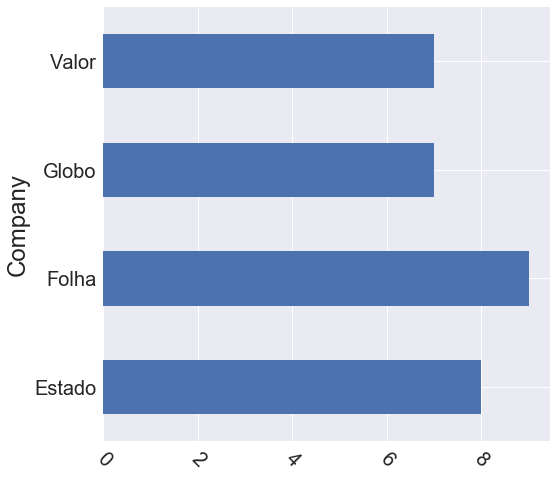

In [67]:
ax = df.groupby("Company")["Length"].median().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)

# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

Claramente podemos ver que a "Folha de São Paulo", na média, utiliza mais palavras em suas manchetes.

### Criação de uma nova coluna para o tamanho de cada manchete - Stopwords

Stopwords: São palavras que podem ser consideradas irrelevantes para o conjunto de resultados a ser exibido em uma busca realizada em uma search engine [1]. Estas palavras são usadas para definir a estrutura de uma frase. Mas, não são de nenhum uso em definir o contexto.
Alguns exemplos de Stopwords:
* Linguagem – a, o, de, da, que, em, um.

Vamos repetir a mesma análise anterior, porém retirando as "stopwords". Para isso vamos utilizar um método da biblioteca NLTK, que nos fornece facilmente algumas stopwords da Lingua Portuguesa.

A função abaixo faz o split de cada manchete, conta as palavras sem as stopwords e atribui o valor númerico a uma nova coluna (Lenght_Filtered)

[1] http://www.agenciamestre.com/seo/stop-words-como-funcionam-palavras-de-parada/

In [68]:
stopwords = nltk.corpus.stopwords.words('portuguese')
df['Length_Filtered'] = df['Headline'].apply(lambda x: len(set(x.split()).difference(stopwords)) )
df.head()

,Day,Month,Year,Company,Headline,Length,Length_Filtered
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10,7
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7,6
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7,5
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9,5
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8,6


### Número de médio de palavras sem stopwords

O gráfico abaixo ilustra o número médio de palavras utilizadas nas manchetes de cada Jornal


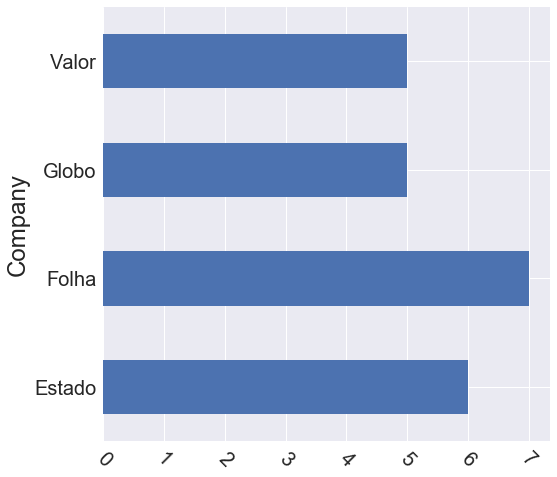

In [69]:
ax = df.groupby("Company")["Length_Filtered"].median().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)

# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

Mesmo após a remoção das stopwors, o jornal "Folha de São Paulo" ainda tem o maior número médio de palavras em suas manchetes.

Esta pré análise vai nos ajudar a verificar se o número de palavras foi um fator relevante ou não na determinação da valência de cada manchete. 

# POS Tagging - Análise usando MAC Morpho

Mac-Morpho é um corpus de textos em português brasileiro anotado com tags de part-of-speech. Sua primeira versão foi lançada em 2003 [1], e desde então, duas revisões foram feitas para melhorar a qualidade do recurso [2, 3].

A biblioteca NLTK nos permite utilizar o MAC Morpho facilmente.

http://nilc.icmc.usp.br/macmorpho/

** Abaixo segue uma análise quantitativa e qualitativa utilizando o MAC Morpho com respeito aos "nomes", "adjetivos" e "verbos".**

In [70]:
import nltk.corpus
dict_morpho = dict(nltk.corpus.mac_morpho.tagged_words())

In [71]:
# Função responsável por desenhar as Word Clouds
def wordcloud_draw(data, color = 'white', title= ""):
    words = ' '.join(data)
    wordcloud = WordCloud(
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(words)
    plt.figure(1,figsize=(8, 8))
    plt.title(title, fontsize=20)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

### Criação de uma nova coluna para a quantidade de Adjetivos de cada manchete

A função abaixo faz o split de cada manchete, conta os adjetivos sem as stopwords e atribui o valor númerico a uma nova coluna (Adjectives_count)

In [72]:
adjectives = []
def adj_count(sentence):
    headlines = [w for w in sentence.split() if w not in stopwords and w.isalpha()]
    adj_count = 0
    for word in headlines:
        try:
            if dict_morpho[word] == "ADJ":
                adj_count += 1
                adjectives.append(word)
        except:
            pass
    return adj_count
df['Adjectives_Count'] = df['Headline'].apply(lambda x: adj_count(x))
df.head()

,Day,Month,Year,Company,Headline,Length,Length_Filtered,Adjectives_Count
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10,7,0
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7,6,1
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7,5,0
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9,5,0
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8,6,0


### Worcloud de Adjetivos

A Word Cloud é uma maneira fácil de visualizarmos as palavras mais frequentes dentro de um corpus.

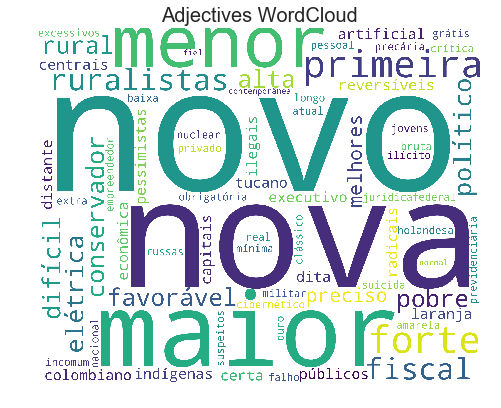

In [73]:
wordcloud_draw(adjectives, "white", "Adjectives WordCloud")

### Criação de uma nova coluna para a quantidade de Nomes de cada manchete

A função abaixo faz o split de cada manchete, conta os nomes sem as stopwords e atribui o valor númerico a uma nova coluna (Nouns_count)

In [74]:
nouns = []
def sub_count(sentence):
    headlines = [w for w in sentence.split() if w not in stopwords and w.isalpha()]
    adj_count = 0
    for word in headlines:
        try:
            if dict_morpho[word] == "N":
                adj_count += 1
                nouns.append(word)
        except:
            pass
    return adj_count
df['Nouns_Count'] = df['Headline'].apply(lambda x: sub_count(x))
df.head()

,Day,Month,Year,Company,Headline,Length,Length_Filtered,Adjectives_Count,Nouns_Count
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10,7,0,3
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7,6,1,2
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7,5,0,0
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9,5,0,2
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8,6,0,2


### Worcloud de Nomes

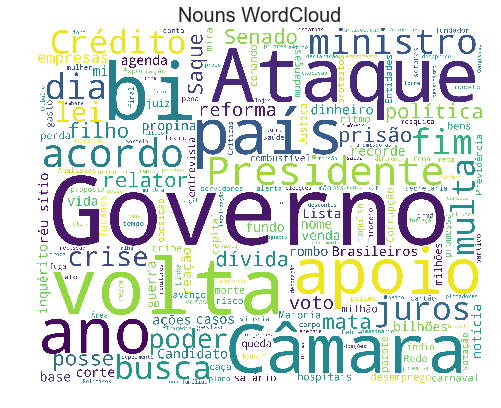

In [75]:
wordcloud_draw(nouns, "white", "Nouns WordCloud")

### Criação de uma nova coluna para a quantidade de Verbos de cada manchete

A função abaixo faz o split de cada manchete, conta os verbos sem as stopwords e atribui o valor númerico a uma nova coluna (Verbs_count)

In [76]:
verbs = []
def verb_count(sentence):
    headlines = [w for w in sentence.split() if w not in stopwords and w.isalpha()]
    adj_count = 0
    for word in headlines:
        try:
            if dict_morpho[word] == "V":
                adj_count += 1
                verbs.append(word)
        except:
            pass
    return adj_count
df['Verbs_Count'] = df['Headline'].apply(lambda x: verb_count(x))
df.head()

,Day,Month,Year,Company,Headline,Length,Length_Filtered,Adjectives_Count,Nouns_Count,Verbs_Count
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10,7,0,3,0
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7,6,1,2,1
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7,5,0,0,1
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9,5,0,2,1
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8,6,0,2,1


### Worcloud de Verbos

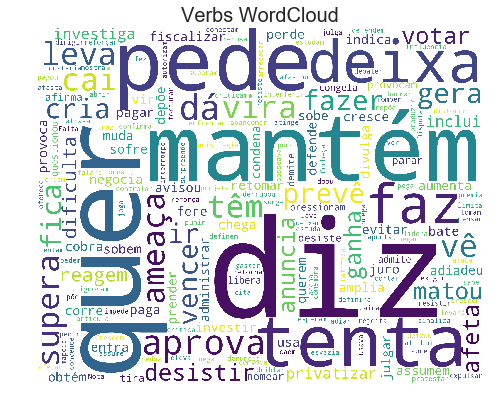

In [77]:
wordcloud_draw(verbs, "white", "Verbs WordCloud")

Podemos ver que o MAC Morpho nos forneceu um bom resultado classificando os tokens, mas poderia ser melhor especialmente ao lidar com verbos que não estejam na forma infinitiva. A lematização poderia resolver este problema, mas o NLTK não possui um bom suporte para a língua portuguesa em relação à prover verbos no infinito. Apesar de contar com recurso de stemming, este acaba também não sendo uma boa solução neste caso pois os dicionários utilizados não contém estas abreviações.

# Análise de frequência de palavras

Vamos apresentar as palavras mais frequentes nas manchetes dos jornais, assim como fizemos com as Word Clouds.
Porém, agora sem a utilização do MAC Morpho. Vamos apenas retirar as stopwords e identificar as palavras mais frequentes.

In [78]:
# Remove todas as stopwords
dataframe = pd.DataFrame(df['Headline'])

names = []
def funcao(sentence):
    stopwords = nltk.corpus.stopwords.words('portuguese')
    words = [w for w in sentence.lower().split() if w not in stopwords and w.isalpha()]
    return words

dataframe['stopwords'] = df['Headline'].apply(lambda x: funcao(x))

Através do método "FreqDist" da biblioteca NLTK podemos facilmente identificar a frequência das palavras, conforme mostrado abaixo. Obs: Por simplificação, estamos exibindo apenas as palavras que aparecem mais de cinco vezes.

In [79]:
all_words = []
for x in dataframe.stopwords:
    for y in x:
        all_words.append(y)

fd_words = nltk.FreqDist(all_words)
print ("Palavra, Frequência")
for i,x in enumerate(fd_words.most_common()):
    if x[1] > 5:
        print(x)

Palavra, Frequência
('diz', 21)
('temer', 19)
('trump', 18)
('governo', 17)
('é', 17)
('deve', 15)
('quer', 13)
('vai', 13)
('contra', 13)
('novo', 12)
('sobre', 12)
('volta', 11)
('doria', 11)
('brasil', 11)
('bi', 11)
('pode', 10)
('país', 9)
('mantém', 9)
('eua', 8)
('stf', 8)
('sp', 8)
('câmara', 8)
('vão', 8)
('odebrecht', 8)
('ataque', 8)
('crise', 7)
('ter', 7)
('pede', 7)
('tenta', 7)
('apoio', 7)
('bc', 6)
('após', 6)
('nova', 6)
('presidente', 6)
('jbs', 6)
('acordo', 6)
('fim', 6)
('fgts', 6)
('deixa', 6)
('febre', 6)


** Esta análise nos permite visualizar as palavras que teriam maior relevância no corpus e, talvez, serem adicionadas e/ou modificadas nos dicionários léxicos que veremos adiante. **

## Identificação de manchetes repetidas

Identificamos a existência de 12 manchetes repetidas no dataset. Uma abordagem para corrigir o problema seria identificar qual é a notícia verdadeira (pertencente ao jornal original) e remover a falsa. Porém, optamos por manter o dataset original, uma vez que teríamos que realizar um trabalho manual de verificação ou a criação de um parser para buscar as notícias verdadeiras.

In [80]:
aux = df[['Company','Headline']][df.Headline.duplicated(keep=False)] #value_counts(sort=True)
print ("The dataset has", aux.Headline.count(),"news duplicated")

aux.sort_values("Headline",ascending=True)

The dataset has 24 news duplicated


,Company,Headline
490,Estado,Contas do govertno têm maior rombo da história.
434,Valor,Contas do govertno têm maior rombo da história.
488,Estado,Contas inativas do FGTS devem injetar R$ 41 bi na economia.
432,Valor,Contas inativas do FGTS devem injetar R$ 41 bi na economia.
435,Valor,"Doria congela R$ 2,6 bi de Saúde e Educação."
491,Estado,"Doria congela R$ 2,6 bi de Saúde e Educação."
87,Valor,EUA vão fiscalizar Odebrecht e Braskem.
448,Globo,EUA vão fiscalizar Odebrecht e Braskem.
413,Folha,Embaixada do Brasil cria plano de fuga da Coreia.
416,Folha,Embaixada do Brasil cria plano de fuga da Coreia.


# Análise Léxica

Os arquivos referentes aos dicionários léxicos foram baseados em https://github.com/pedrobalage/STIL_LIWC_Evaluation, sendo:
- OpLexiconReader - OPLexicon 3.0
- SentiLexReader - Sentilex PT02
- LiwcReader - Linguistic Inquiry and Word Count

Estes dicionários apresentam características semelhantes entre si, como a presença de polaridades para algumas palavras e em alguns casos para algumas expressões. Em ambos, as polaridades são expressas como:

- -1: Sentimento negativo
- 0: Sentimento Neutro
- 1: Sentimento Positivo

In [81]:
#import lexical
from lexical import OpLexiconReader
from lexical import SentiLexReader
from lexical import LiwcReader

#### Exemplo do OpLexicon 3.0

In [82]:
oplexicon = OpLexiconReader()
sentence = df["Headline"][1].split()
for w in sentence:
    print(w, oplexicon.polarity(w))

BC None
cria None
novo 1
instrumento None
de None
política 0
monetária. None


#### Exemplo do SentiLex PT02

In [83]:
sentilex =  SentiLexReader()
for w in sentence:
    print(w, sentilex.polarity(w))

BC None
cria None
novo None
instrumento None
de None
política None
monetária. None


#### Exemplo do LIWC

In [84]:
liwc =  LiwcReader()
for w in sentence:
    print(w, liwc.polarity(w))

BC None
cria 1
novo 0
instrumento 0
de 0
política 0
monetária. None


O resultado acima para ambos os dicionários léxicos nos alerta que várias palavras não estão presentes, o que afeta bastante a eficácia de análise de polaridade. Entretanto, iremos tentar realizar análise de sentimentos baseado neles.

# Análise de sentimento

A função abaixo retorna a polaridade de acordo com o dicionário léxico passado. Com objetivo de manter as dimensões entre -1 e 1, nós decidimos realizar a soma de todas as polaridades e tirar a média relacionada às palavras contidas nos dicionários. Portanto, palavras que não estão presentes nos dicionários não influenciam na média final. Deste modo, a análise de sentimento usando os dicionários léxicos existentes puderam ser melhorados, mesmo com a inexistência de alguns termos e palavras.

In [85]:
def extract_sentiment_lexical(sentence, lexical):
    model = oplexicon if lexical == "oplexicon" else liwc if lexical =="liwc" else sentilex
    original_words = sentence.split()
    stopwords = nltk.corpus.stopwords.words('portuguese')
    #words = [w for w in original_words] 
    words = [w for w in original_words if w not in stopwords and w.isalpha()]  

    sum_lexical, count_lexical = 0, 0
    for w in words:
        pol_lexical = model.polarity(w)
        if pol_lexical is not None:
            sum_lexical += pol_lexical
            count_lexical += 1
        
    mean_lexical = sum_lexical/count_lexical if count_lexical != 0 else 0
    #print(sentence, mean_lexical)
    return mean_lexical
    
df['OpLexicon_Score'] = df['Headline'].apply(lambda x: extract_sentiment_lexical(x, "oplexicon"))
df['SentiLex_Score'] = df['Headline'].apply(lambda x: extract_sentiment_lexical(x, "sentilex"))
df['LIWC_Score'] = df['Headline'].apply(lambda x: extract_sentiment_lexical(x, "liwc"))
df.head()

,Day,Month,Year,Company,Headline,Length,Length_Filtered,Adjectives_Count,Nouns_Count,Verbs_Count,OpLexicon_Score,SentiLex_Score,LIWC_Score
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10,7,0,3,0,0.0,0.0,-0.20
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7,6,1,2,1,0.5,0.0,0.25
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7,5,0,0,1,0.0,0.0,1.00
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9,5,0,2,1,0.0,1.0,0.50
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8,6,0,2,1,0.0,0.0,0.00


### Análise ao longo do tempo

Com o objetivo de entender as mudanças de sentimento relacionadas às manchetes ao longo do tempo, foi proposta uma visualização definida através dos meses (sendo estes transformados para o formato adequado) juntamente com uma análise comparativa da polaridade resultante de cada dicionário léxico.

In [86]:
import datetime as dt

dict1 = {'janeiro':1,
         'fevereiro':2,
         'março':3, 
         'abril':4,
         'maio':5,
         'junho':6,
         'julho':7,
         'agosto':8,
         'setembro':9,
         'outubro':10, 
         'novembro':11,
         'dezembro':12}
df['Month_number'] = df.Month.map(dict1)

df.head()

,Day,Month,Year,Company,Headline,Length,Length_Filtered,Adjectives_Count,Nouns_Count,Verbs_Count,OpLexicon_Score,SentiLex_Score,LIWC_Score,Month_number
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10,7,0,3,0,0.0,0.0,-0.20,2
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7,6,1,2,1,0.5,0.0,0.25,2
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7,5,0,0,1,0.0,0.0,1.00,2
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9,5,0,2,1,0.0,1.0,0.50,2
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8,6,0,2,1,0.0,0.0,0.00,2


In [87]:
df['DateTime'] = df[['Year', 'Month_number', 'Day']].apply(lambda s : dt.datetime(*s),axis = 1)
df.head()

,Day,Month,Year,Company,Headline,Length,Length_Filtered,Adjectives_Count,Nouns_Count,Verbs_Count,OpLexicon_Score,SentiLex_Score,LIWC_Score,Month_number,DateTime
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás,10,7,0,3,0,0.0,0.0,-0.20,2,2017-02-01
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.,7,6,1,2,1,0.5,0.0,0.25,2,2017-02-01
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.,7,5,0,0,1,0.0,0.0,1.00,2,2017-02-01
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já chega à tarifa.,9,5,0,2,1,0.0,1.0,0.50,2,2017-02-01
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do trigo"".",8,6,0,2,1,0.0,0.0,0.00,2,2017-02-01


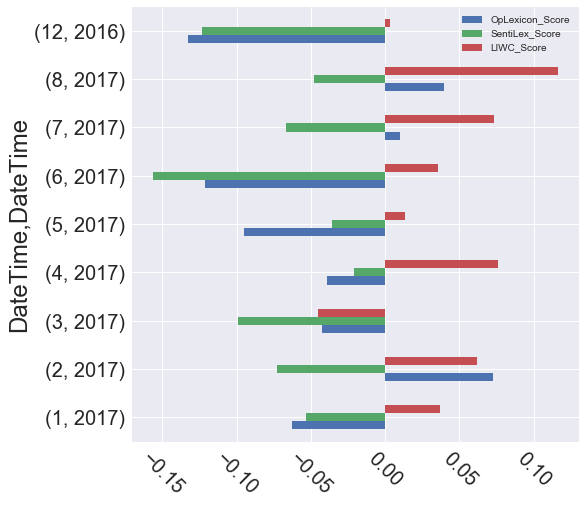

In [88]:
df.index = df.DateTime

#ax = df.set_index(df.Month).sort_index().groupby("Month",sort=False, axis=0)["OpLexicon_Score","SentiLex_Score","LIWC_Score"].mean().plot(kind="barh", figsize=(8, 8))
ax = pd.Series.groupby(df,by=[df.index.month,df.index.year],sort=True, axis=0)["OpLexicon_Score","SentiLex_Score","LIWC_Score"].mean().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)


# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

Pode-se notar analisando a figura acima, que não só existe muita variação entre o resultado de polaridade do sentimento para cada dicionário léxico, como também existe uma tendência que a análise de sentimento de um contexto geral se aproxime de neutro, já que valores entre -0.15 e 0.15 estão bem próximos ao valor padrão assumido para neutro que seria 0.

### Comparação entre os dicionários léxicos

Para afirmar a hipótese de que cada dicionário léxico apresenta resultados diferentes e que também o contexto geral das manchetes tende ao sentimento neutro, é proposto abaixo histogramas demonstrando a distribuição de sentimento no dataset.

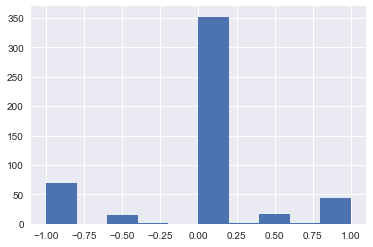

In [89]:
df["OpLexicon_Score"].hist()

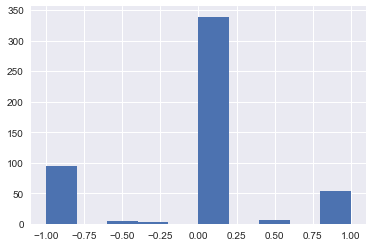

In [90]:
df["SentiLex_Score"].hist()

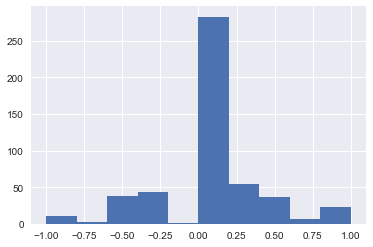

In [91]:
df["LIWC_Score"].hist()

Primeiramente, de uma forma geral, todos os dicionários apresentaram uma quantidade muito elevada de manchetes neutras. Pode-se assumir duas possíveis conclusões em relação a isto:
- As manchetes apresentam poucas palavras contidas nos dicionários léxicos, portanto com a inexistência destas palavras acaba-se assumindo o valor padrão 0 para neutro.
- Notícias de economia e política estão predominantemente presentes no conjunto de dados sendo as manchetes destas, na sua maior parte, compostas por palavras neutras.

Pode-se observar também que os dicionários apresentam certa divergência entre si, principalmente quando se relaciona o LIWC com os demais. Nota-se uma distribuição menos discretizada em -1, 0 e 1 no dicionário léxico do LIWC, devido ao fato deste conter um número de palavras maior e que se assemelham mais com as manchetes propostas.

### OpLexicon Score Analysis by Company

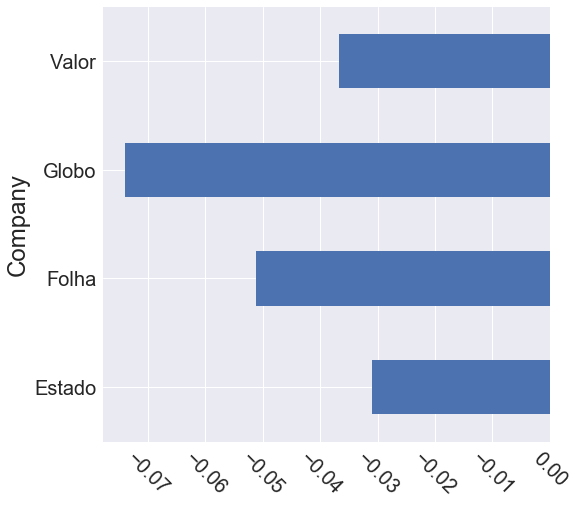

In [92]:
ax = df.groupby("Company")["OpLexicon_Score"].mean().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)

# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

### SentiLex Score Analysis by Company

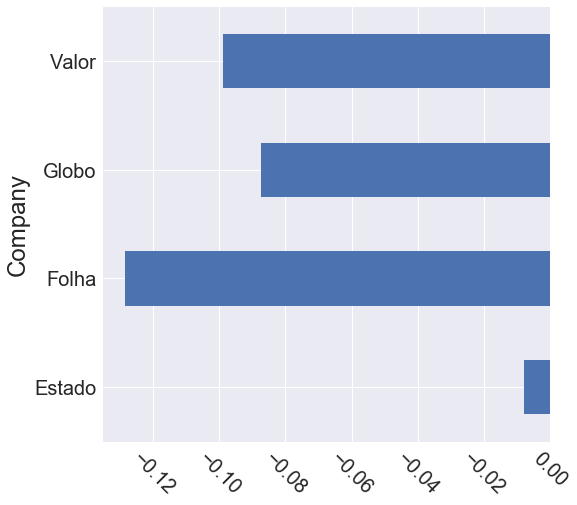

In [93]:
ax = df.groupby("Company")["SentiLex_Score"].mean().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)

# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

### LIWC Score Analysis by Company

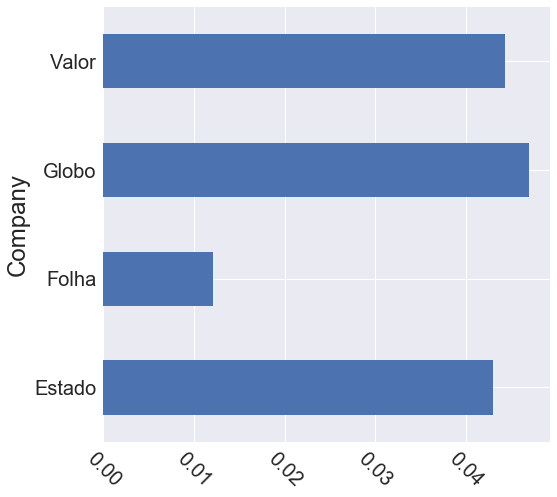

In [94]:
ax = df.groupby("Company")["LIWC_Score"].mean().plot(kind="barh", figsize=(8, 8))

# resize y label
ylabel = ax.yaxis.get_label()
ylabel.set_fontsize(24)

# resize x tick labels
labels = ax.yaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels];

# resize y tick labels
labels = ax.xaxis.get_ticklabels()
[label.set_fontsize(20) for label in labels]
[label.set_rotation(-45) for label in labels];

# Análise de manchetes em tempo real

#### In order to analyse and compare which news are most important in the moment and their polarity, we propose a real time sentiment parser for both Folha, Valor and O Globo websites.

In [95]:
def parser(website):
    r = requests.get(website)
    content = r.content
    soup = BeautifulSoup(content, "html.parser")
    headings = soup.find_all(re.compile(r"^h\d$"))
    company = []
    for h in headings:
        # avoid ads
        if len(h.text.strip().split()) > 6:
            company.append(str.strip(h.text))
    return company

In [96]:
valor_news = parser("http://www.valor.com.br/")
globo_news = parser("https://oglobo.globo.com/")
folha_news = parser("http://www.folha.uol.com.br/")
estadao_news = parser("http://www.estadao.com.br/")

## Folha Top 10

In [97]:
for sentence in folha_news[:10]:
    score_oplexicon = extract_sentiment_lexical(sentence, "oplexicon")
    score_sentilex = extract_sentiment_lexical(sentence, "sentilex")
    print(sentence, score_oplexicon, score_sentilex)

Ministro Barroso, do STF, autoriza inquérito para investigar Temer 1.0 0
Flechas apontam para Temer em gráfico do 'quadrilhão' do PMDB 0.0 0
Provas devem ser mantidas em delações problemáticas, diz Bretas 0.5 0
PMDB deve afastar Geddel nesta quarta-feira para tentar isolar crise 0.3333333333333333 0.0
PT prepara ato menor para Lula em Curitiba, mas teme hostilidade 0.0 -1.0
Palocci fere narrativa de perseguição de Lula, diz Ciro Gomes 0 0.0
Doria decide congelar IPTU de São Paulo no ano eleitoral de 2018 0.0 0
Alckmin viaja em voo comercial e divulga foto em fila de aeroporto 0.0 0
Impasse permanece e votação da reforma política é adiada de novo 0.5 0
Medida do Senado põe em risco arrecadação de R$ 2 bilhões 0 0


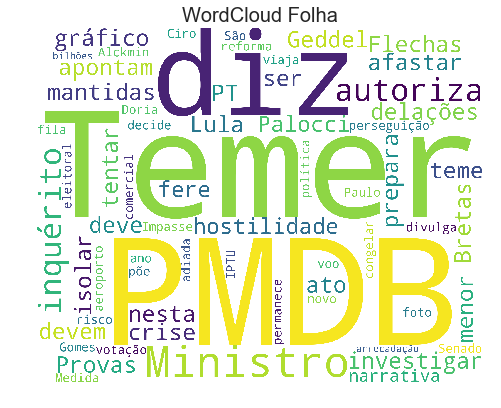

In [98]:
words = []
for sentence in folha_news[:10]:
    for w in sentence.split():
        if w not in stopwords and w.isalpha():
            words.append(w) 
        
wordcloud_draw(words, "white" ,"WordCloud Folha")

## Valor Top 10

In [99]:
for sentence in valor_news[:10]:
    score_oplexicon = extract_sentiment_lexical(sentence, "oplexicon")
    score_sentilex = extract_sentiment_lexical(sentence, "sentilex")
    print(sentence, score_oplexicon, score_sentilex)

Votação da reforma política fica para esta quarta-feira, diz líder do PMDB 0.0 0
Barroso, do STF, autoriza abertura de inquérito contra Temer 0 0
Fortuna das famílias mais ricas do mundo aumenta apesar de crises e turbulências 1.0 1.0
Participantes terão de aportar R$ 14 bi no fundo de pensão dos funcionários da Petrobras 0.0 0
MPF denuncia ex-presidente da Funcef e mais 9 por gestão fraudulenta -1.0 -1.0
OAB suspende
temporariamente
carteira do ex-procurador Marcelo Miller 0 0
Defesa de Lula recorre na 2ª instância sobre caso do triplex 0 0
Para Gilmar Mendes, STF "está vivendo maior vexame de sua história" 0.0 0
Doria defende privatizar Petrobras e unir Caixa com BB 0.0 0
Copom reforça intenção de reduzir ritmo de corte de taxa básica de juro -0.5 -1.0


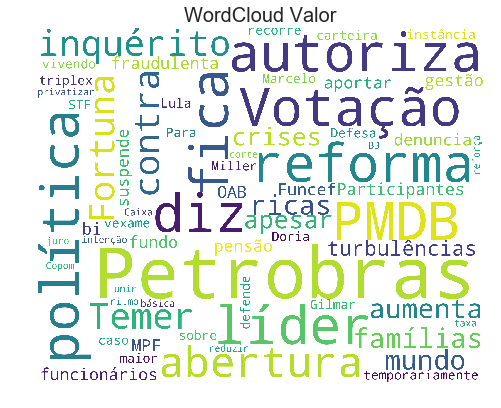

In [100]:
words = []
for sentence in valor_news[:10]:
    for w in sentence.split():
        if w not in stopwords and w.isalpha():
            words.append(w) 
        
wordcloud_draw(words, "white" ,"WordCloud Valor")

## O Globo Top 10

In [101]:
for sentence in globo_news[:10]:
    score_oplexicon = extract_sentiment_lexical(sentence, "oplexicon")
    score_sentilex = extract_sentiment_lexical(sentence, "sentilex")
    print(sentence, score_oplexicon, score_sentilex)

Funaro diz que Temer se beneficiou de propina da usina de Angra 3 0 0
Cúpula do PMDB cobrou propina em empréstimos do FI-FGTS 0 0
Corretor pagará multa R$ 4 milhões por acordo 0 0
Como Joesley comprou o silêncio de Funaro 0 0
Delator relata invasão de sua casa, vizinha a um imóvel de Joesley 0.5 -1.0
Temer e Cunha estão no centro do 'quadrilhão' do PMDB, afirma PF 0 0
Presidente convoca aliados para café da manhã a fim de traçar estratégia contra denúncia 0.5 0.0
Barroso abre novo inquérito no Supremo para investigar Temer 1.0 0
Cunha ficará temporariamente em presídio de Brasília 0 0
Novo inquérito contra Temer e o novo iPhone 1.0 0


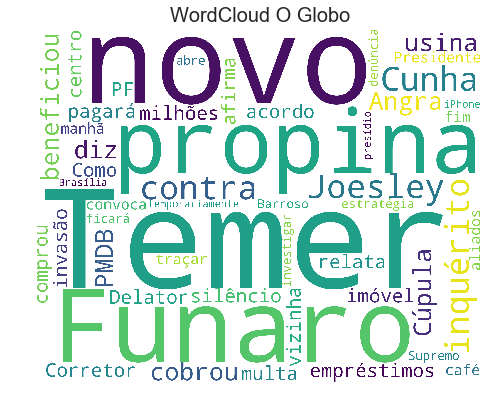

In [102]:
words = []
for sentence in globo_news[:10]:
    for w in sentence.split():
        if w not in stopwords and w.isalpha():
            words.append(w) 
        
wordcloud_draw(words, "white" ,"WordCloud O Globo")

## Estadão Top 10

In [103]:
for sentence in estadao_news[:10]:
    score_oplexicon = extract_sentiment_lexical(sentence, "oplexicon")
    score_sentilex = extract_sentiment_lexical(sentence, "sentilex")
    print(sentence, score_oplexicon, score_sentilex)

Estadão - Portal do Estado de S. Paulo 0 0
Quase um terço dos membros da CPI da JBS foi financiado pela empresa 0 0
J&F contratou escritório de advocacia um dia antes de gravar Temer -1.0 0
Projeto abre brecha para criação de fundo eleitoral 0 0
Funaro relata ao Supremo que sua casa em SP foi invadida 0 0
Maioria da 2ª Turma vota para tornar réus Pizzolati e Negromonte -0.5 -0.5
Novo Refis fica ainda mais benéfico para devedores 1.0 1.0
Doria agora admite prévias com Alckmin no PSDB 0.0 0
Apple lança iPhone X, sem botão e quase sem borda 0 0
Ato a favor de exposição termina com dois presos 0.0 -1.0


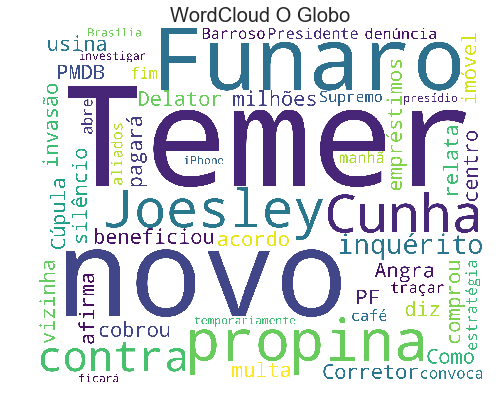

In [104]:
words = []
for sentence in globo_news[:10]:
    for w in sentence.split():
        if w not in stopwords and w.isalpha():
            words.append(w) 
        
wordcloud_draw(words, "white" ,"WordCloud O Globo")